## Adjustment

In [ ]:
from logging import raiseExceptions
from datetime import date
import os
global wilayah
global kolom
global found_wilayah

jenis_peta = ['Verifikasi']      #contoh: ['Prakiraan', 'Analisis','Probabilistik','Verifikasi'] apabila ingin membuat map lebih dari satu, misal contoh: [Prakiraan, Analisis, Verifikasi] tolong isi di dalam tanda kurung
tipe_peta  = ['Curah Hujan','Sifat Hujan']    #['Curah Hujan', 'Sifat Hujan'] tolong isi di dalam tanda kurung
skala_peta = ['Bulanan']       #['Bulanan','Dasarian'] tolong isi di dalam tanda kurung
year = 2026
year_ver = 2026
months = [1]                 #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] tolong isi di dalam tanda kurung
month_ver = 1           #update versi bulan berapa
wilayah = "Papua Barat Daya, Papua Barat" #diganti sesuai nama provinsi yang diinginkan (contoh jika dipilih lebih dari satu prov: Jawa Timur, Bali)
dasarian = 3
dasarian_ver = 2
file_prakiraan = "cfsicjan"       #diganti sesuai nama file yang diupload
type_prakiraan = ".csv"
file_analisis = "analisis2601"         #diganti sesuai nama file yang diupload
type_analisis = ".xls"
hgt = False                         #hgt (layer laut) contoh: True, False

In [ ]:
# Cek keberadaan file5
if 'Prakiraan' in jenis_peta:
    if not os.path.exists(file_prakiraan + type_prakiraan):
        raise FileNotFoundError(f"File tidak ditemukan: {file_prakiraan + type_prakiraan}")
    else:
        print(f"File ditemukan: {file_prakiraan + type_prakiraan}")

if 'Analisis' in jenis_peta:
    if not os.path.exists(file_analisis + type_analisis):
        raise FileNotFoundError(f"File tidak ditemukan: {file_analisis + type_analisis}")
    else:
        print(f"File ditemukan: {file_analisis + type_analisis}")

# Library

## Packages

In [ ]:
import subprocess
import sys
import importlib.util

packages = ["scikit-learn","pyinterpolate","rioxarray","python-docx","fuzzywuzzy","netCDF4","cartopy","dask","pandas"]
for package in packages:
    spec = importlib.util.find_spec(package)
    if spec is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

print("All required packages are now installed.")
from docx import Document
from docx.shared import Inches
import json
import rasterio
import rasterio.plot
from rasterio.io import MemoryFile
import re
from google.colab import drive
from google.auth import default
from googleapiclient.discovery import build
from google.colab import auth
from io import BytesIO
from googleapiclient.http import MediaIoBaseDownload
import matplotlib.pyplot as plt
#!pip uninstall -y numpy pandas
#!pip install numpy pandas--upgrade pandas
import pandas as pd
import numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from sklearn.metrics import cohen_kappa_score
import rioxarray
import xarray as xr
from scipy.spatial import cKDTree
%matplotlib inline
from datetime import datetime
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import matplotlib.font_manager as fm
import os
from matplotlib.patches import Rectangle
import io
import base64
from googleapiclient.http import MediaIoBaseUpload
from docx import Document
from docx.shared import Inches
from PIL import Image
from fuzzywuzzy import process
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import gc

# Suppress all warnings
warnings.filterwarnings("ignore")

global max_day
max_day = None

pyinterpolate is already installed.
rioxarray is already installed.
fuzzywuzzy is already installed.
netCDF4 is already installed.
cartopy is already installed.
dask is already installed.
pandas is already installed.
All required packages are now installed.


## Authentication

In [ ]:
#Authenticate and create the Drive API client
auth.authenticate_user()
creds, _ = default()
drive_service = build('drive', 'v3', credentials=creds)
#docs_service = build('docs', 'v1', credentials=creds)

# ID of the shared folder
#prakiraan_id    = '1veIKADpp74B5I5s5dCJkKGdHLie0BHhK'
#analisis_id    = '1f0IY2RVWW6PR37tc75LEtF62ys_9klES'
#prakdas_id     = '1ogk2oJsAxTtAmTRnDQagckls5TtUPYDP'
#analisisdas_id = '1jYy8kra2a8zMxrVi2wwEHkCigwHOls-v'
input_id      = '1gpCIg1aiB9_DOW0t2ulMhSTMGT_WHP86'
output_id     = '1DXZjCVQt7gPIkrNZv4n59-X7_WF-HF8h'

#drive.mount('/content/drive/')
#parent_folder = 'Analisis_Geostatistik'
#wdir = f"/content/drive/My Drive/{parent_folder}/"


# Functions

## Drive management

In [ ]:
def get_subfolder_id(parent_id, folder_name):
    try:
      print(f"\rFolder name: {folder_name}", end="",flush = True)
      query = f"'{parent_id}' in parents and name = '{folder_name}' and mimeType = 'application/vnd.google-apps.folder'"
      results = drive_service.files().list(q=query, fields="files(id, name)").execute()
      folders = results.get('files', [])
    except:
      raise Exception("Subfolder not found")
    return folders[0]['id'] if folders else None

def get_file_id(folder_id, file_name):
    try:
      query = f"'{folder_id}' in parents and name = '{file_name}'"
      results = drive_service.files().list(q=query, fields="files(id, name)").execute()
      files = results.get('files', [])
      if files:
          return files[0]['id']
      else:
          raise Exception(f"Error finding file {file_name}, kemungkinan file belum tersedia")
    except Exception as e:
        raise Exception(f"Error finding file: {str(e)}")

def process_file(file_id):
    if not file_id:
        raise Exception("File ID not found/provided")
    try:
        # Get the file metadata
        file_metadata = drive_service.files().get(fileId=file_id, fields='mimeType').execute()
        mime_type = file_metadata['mimeType']

        if mime_type == 'application/vnd.google-apps.document':
            # For Google Docs, we need to export
            request = drive_service.files().export_media(fileId=file_id, mimeType='application/vnd.openxmlformats-officedocument.wordprocessingml.document')
        else:
            # For other file types, we can download directly
            request = drive_service.files().get_media(fileId=file_id)

        fh = BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
        fh.seek(0)
        return fh
    except Exception as e:
        raise Exception(f"File could not be processed: {str(e)}")

def list_folders(folder_id):
    query = f"'{folder_id}' in parents and mimeType = 'application/vnd.google-apps.folder'"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    folders = results.get('files', [])
    return folders

def build_df(fh):
    if not fh:
        print("File handle not provided.")
        return None

    # Read the first few bytes to determine the file type
    fh.seek(0)
    header = fh.read(8)
    fh.seek(0)  # Reset file pointer to the beginning

    try:
        # Check for Excel file signatures
        if header.startswith(b'\x50\x4B\x03\x04') or header.startswith(b'\xD0\xCF\x11\xE0'):
            df = pd.read_excel(fh) # This covers both old (.xls) and new (.xlsx, .xlsm) Excel formats
        else:
            df = pd.read_csv(fh) # If not Excel, assume it's CSV or similar tabular format
        if df.empty: # Basic check to ensure we have a non-empty DataFrame
            raise ValueError("The file appears to be empty or not in a recognized tabular format.")

        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

## Font

In [ ]:
def font_path(font_style):
    if not os.path.isfile('fonts/ARIALBD.TTF'):
        # Download and install the font
        !wget https://font.download/dl/font/arial.zip
        !unzip arial.zip
        os.remove('arial.zip')
        # Create a fonts directory in the current working directory
        !mkdir -p fonts

        # Move all TTF files to the fonts directory
        !mv *.TTF *.ttf fonts/
    else:
        None
    font_files = {
    'regular': 'fonts/ARIAL.TTF',
    'bold': 'fonts/ARIALBD.TTF',
    'italic': 'fonts/ARIALI.TTF',
    'bold_italic': 'fonts/ARIALBI.TTF',
    'narrow': 'fonts/ARIALN.TTF',
    'narrow_bold': 'fonts/ARIALNB.TTF',
    'narrow_italic': 'fonts/ARIALNI.TTF',
    'narrow_bold_italic': 'fonts/ARIALNBI.TTF',
    'black': 'fonts/ARIBLK.TTF',
    'light': 'fonts/ARIALLGT.TTF',
    'medium': 'fonts/ArialMdm.ttf',
    'medium_italic': 'fonts/ArialMdmItl.ttf'}
    return font_files[font_style]

## Basemap

In [ ]:
_drive_cache = {}

def get_cached_file(folder_id, filename):
    key = (folder_id, filename)
    if key not in _drive_cache:
        file_id = get_file_id(folder_id, filename)
        fh = process_file(file_id)
        _drive_cache[key] = fh.getvalue()
    return BytesIO(_drive_cache[key])


_basemap_cache = {}
_idkab_cache = None

def load_idkab():
    global _idkab_cache
    if _idkab_cache is None:
        basemap_folder = '142rWd5aaqvnaIlZau8f0yqnyglpXODVH'
        kab_filename = "idkab.feather"
        basemap_kab = get_cached_file(basemap_folder, kab_filename)
        _idkab_cache = gpd.read_feather(basemap_kab)
        print(f"\rfeather loaded", end="", flush=True)
    return _idkab_cache


def flexible_match(query, choices, threshold=80):
    if query in choices:
        return query

    prefixes = ["Kota", "Kabupaten"]
    for prefix in prefixes:
        if not query.startswith(prefix):
            prefixed_query = f"{prefix} {query}"
            if prefixed_query in choices:
                return prefixed_query

    matches = process.extractBests(query, choices, score_cutoff=threshold, limit=1)
    if matches:
        return matches[0][0]

    for prefix in prefixes:
        if not query.startswith(prefix):
            prefixed_query = f"{prefix} {query}"
            matches = process.extractBests(prefixed_query, choices, score_cutoff=threshold, limit=1)
            if matches:
                return matches[0][0]
    return None


def load_basemap(wilayah):
    idkab = load_idkab()

    if isinstance(wilayah, str):
        wilayah_list = [w.strip() for w in wilayah.split(',')]
    elif isinstance(wilayah, list):
        wilayah_list = [w.strip() for w in wilayah]
    else:
        raise ValueError("wilayah must be a string (comma-separated) or a list")

    found_wilayah = []
    kolom_types = []

    for kolom in ['PROVINSI', 'KABUPATEN']:
        unique_values = set(idkab[kolom].unique())
        for query in wilayah_list:
            match = flexible_match(query, unique_values)
            if match:
                found_wilayah.append(match)
                kolom_types.append(kolom)

        if not found_wilayah:
            continue

        shp_main = idkab[idkab[kolom].isin(found_wilayah)]
        others_shp = idkab[~idkab[kolom].isin(found_wilayah)]
        shp_crs = idkab.crs
        print(f"\rBasemap loaded for {kolom}: {', '.join(found_wilayah)}", end="", flush=True)

        if len(set(kolom_types)) == 1:
            prefix = 'Provinsi' if kolom_types[0] == 'PROVINSI' else 'Kabupaten'
            if len(found_wilayah) == 1:
                formatted_title = f"{prefix} {found_wilayah[0]}"
            elif len(found_wilayah) == 2:
                formatted_title = f"{prefix} {found_wilayah[0]} DAN {found_wilayah[1]}"
            else:
                formatted_title = f"{prefix} " + ', '.join(found_wilayah[:-1]) + f", DAN {found_wilayah[-1]}"
        else:
            formatted_titles = []
            for wil, kol in zip(found_wilayah, kolom_types):
                prefix = 'Provinsi' if kol == 'PROVINSI' else 'Kabupaten'
                formatted_titles.append(f"{prefix} {wil}")

            if len(formatted_titles) == 2:
                formatted_title = f"{formatted_titles[0]} DAN {formatted_titles[1]}"
            else:
                formatted_title = ', '.join(formatted_titles[:-1]) + f", DAN {formatted_titles[-1]}"

        return {
            'shp_main': shp_main,
            'others_shp': others_shp,
            'crs': shp_crs,
            'nama_wilayah': formatted_title
        }

    raise ValueError(f"None of the specified wilayah {wilayah_list} found in PROVINSI or KABUPATEN")


def get_basemap(wilayah):
    if wilayah not in _basemap_cache:
        _basemap_cache[wilayah] = load_basemap(wilayah)
    return _basemap_cache[wilayah]

## Loading data

In [ ]:
def load_prakiraan():
    """
    Load prakiraan data from a file named 'prakiraan.csv' or 'prakiraan.xlsx' in the Colab environment.
    Users should rename their file to this standard name when uploading.
    """
    # Check for CSV first, then Excel

    prakiraan_filename = f"{file_prakiraan}{type_prakiraan}"
    if os.path.exists(f"{file_prakiraan}.csv"):
        df_prakiraan = pd.read_csv(prakiraan_filename)
    elif os.path.exists(f"{file_prakiraan}.xlsx"):
        df_prakiraan = pd.read_excel(prakiraan_filename)
    elif os.path.exists(f"{file_prakiraan}.xls"):
        df_prakiraan = pd.read_excel(prakiraan_filename)
    else:
        raise FileNotFoundError("Prakiraan file not found. Please upload a file named 'prakiraan.csv', 'prakiraan.xlsx', or 'prakiraan.xls'.")

    # Process the DataFrame
    df_prakiraan[['LON', 'LAT']] = df_prakiraan[['LON', 'LAT']].round(2)
    print(f"\rFile {prakiraan_filename} loaded successfully", end="", flush=True)
    return df_prakiraan

def load_analisis():
    """
    Load analisis data from a file named 'analisis.csv' or 'analisis.xlsx' in the Colab environment.
    Users should rename their file to this standard name when uploading.
    """
    # Check for CSV first, then Excel
    analisis_filename = f"{file_analisis}{type_analisis}"
    if os.path.exists(f"{file_analisis}.csv"):
        df_analisis = pd.read_csv(analisis_filename)
    elif os.path.exists(f"{file_analisis}.xls"):
        df_analisis = pd.read_excel(analisis_filename)
    elif os.path.exists(f"{file_analisis}.xlsx"):
        df_analisis = pd.read_excel(analisis_filename)
    else:
        raise FileNotFoundError("Analisis file not found. Please upload a file named 'analisis.csv', 'analisis.xlsx', or 'analisis.xls'.")

    # Process the DataFrame
    df_analisis[['LON', 'LAT']] = df_analisis[['LON', 'LAT']].round(2)
    print(f"\rFile {analisis_filename} loaded successfully", end="", flush=True)
    return df_analisis

## Miscellanous

In [ ]:
def categorize_ch(value):
    """
    fallback_strategy: How to handle invalid values
    - 'lowest': Assign to category 1 (most conservative)
    - 'highest': Assign to category 9 (most conservative for high impact)
    - 'middle': Assign to middle category (category 5)
    - 'zero_as_lowest': Treat invalid as 0mm (category 1)
    """
    fallback_strategy='lowest'
    ranges = {
        1: (0, 100),
        2: (101, 300),
        3: (301, 500),
        4: (501, float('inf'))
    }

    # Handle NaN, None, or invalid types
    if pd.isna(value) or value is None:
        if fallback_strategy == 'lowest':
            return 1
        elif fallback_strategy == 'highest':
            return 4
        elif fallback_strategy == 'middle':
            return 2
        elif fallback_strategy == 'zero_as_lowest':
            return 1

    # Handle numpy NaN
    try:
        if np.isnan(value):
            if fallback_strategy == 'lowest':
                return 1
            elif fallback_strategy == 'highest':
                return 4
            elif fallback_strategy == 'middle':
                return 2
            elif fallback_strategy == 'zero_as_lowest':
                return 1
    except (TypeError, ValueError):
        pass

    # Handle non-numeric types
    if not isinstance(value, (int, float, np.integer, np.floating)):
        if fallback_strategy == 'lowest':
            return 1
        elif fallback_strategy == 'highest':
            return 4
        elif fallback_strategy == 'middle':
            return 2
        elif fallback_strategy == 'zero_as_lowest':
            return 1

    # Handle negative values - treat as zero (dry condition)
    if value < 0:
        return 1  # Negative = no rain = lowest category

    # Normal categorization
    for category, (min_val, max_val) in ranges.items():
        if min_val <= value <= max_val:
            return category

    # Shouldn't reach here with comprehensive ranges, but fallback to highest
    return 4

def categorize_index(value):
    """
    fallback_strategy: How to handle invalid values
    - 'lowest': Assign to category 1 (most conservative)
    - 'highest': Assign to category 9 (most conservative for high impact)
    - 'middle': Assign to middle category (category 5)
    - 'zero_as_lowest': Treat invalid as 0mm (category 1)
    """
    fallback_strategy='lowest'
    ranges = {
        1: (0, 20),
        2: (21, 50),
        3: (51, 100),
        4: (101, 150),
        5: (151, 200),
        6: (201, 300),
        7: (301, 400),
        8: (401, 500),
        9: (501, float('inf'))
    }

    # Handle NaN, None, or invalid types
    if pd.isna(value) or value is None:
        if fallback_strategy == 'lowest':
            return 1
        elif fallback_strategy == 'highest':
            return 9
        elif fallback_strategy == 'middle':
            return 5
        elif fallback_strategy == 'zero_as_lowest':
            return 1

    # Handle numpy NaN
    try:
        if np.isnan(value):
            if fallback_strategy == 'lowest':
                return 1
            elif fallback_strategy == 'highest':
                return 9
            elif fallback_strategy == 'middle':
                return 5
            elif fallback_strategy == 'zero_as_lowest':
                return 1
    except (TypeError, ValueError):
        pass

    # Handle non-numeric types
    if not isinstance(value, (int, float, np.integer, np.floating)):
        if fallback_strategy == 'lowest':
            return 1
        elif fallback_strategy == 'highest':
            return 9
        elif fallback_strategy == 'middle':
            return 5
        elif fallback_strategy == 'zero_as_lowest':
            return 1

    # Handle negative values - treat as zero (dry condition)
    if value < 0:
        return 1  # Negative = no rain = lowest category

    # Normal categorization
    for category, (min_val, max_val) in ranges.items():
        if min_val <= value <= max_val:
            return category

    # Shouldn't reach here with comprehensive ranges, but fallback to highest
    return 9

def dasarian_desc(dasarian):
    desc = {1: f"(1-10 {month} {year}",
            2: f"(11-20 {month} {year}",
            3: f"(21-30 {month} {year}",}

def number_to_bulan(month):
    bulan = {1: "Januari", 2: "Februari", 3: "Maret", 4: "April", 5: "Mei", 6: "Juni", 7: "Juli", 8: "Agustus", 9: "September", 10: "Oktober", 11: "November", 12: "Desember"}
    return bulan[month]

def calculate_metrics(forecast_series, actual_series, contingency_table):
    total = contingency_table.loc['All', 'All']

    # Accuracy calculation
    correct = sum(contingency_table.loc[i, i] for i in contingency_table.index if i != 'All'and i in contingency_table.columns)
    accuracy = correct / total

    # Heidke Skill Score
    hss = cohen_kappa_score(actual_series, forecast_series)

    # Pierce Skill Score calculation
    contingency_table_probabilistic = contingency_table.apply(lambda x: x / total, axis=0)
    n_categories = len(contingency_table.index) - 1  # Exclude 'All' row

    pixoi = sum(contingency_table_probabilistic.iloc[i, -1]* contingency_table_probabilistic.iloc[-1, i] for i in range(n_categories))
    hits  = sum(contingency_table_probabilistic.iloc[i, i] for i in range(n_categories))
    oi2   = sum(contingency_table_probabilistic.iloc[-1, i]**2 for i in range(n_categories))
    pss = (hits - pixoi) / (1 - oi2)
    return accuracy, hss, pss

def dasarian_romawi(number):
    das_romawi = {1: 'I', 2: 'II', 3: 'III'}
    return das_romawi[number]

def date_checker():
    # Calculate the difference in months
    forecast_date = date(year, month, 1)
    version_date = date(year_ver, month_ver, 1)
    difference = (forecast_date.year - version_date.year) * 12 + forecast_date.month - version_date.month

    if difference < 0 or difference > 1:
        raise ValueError("Invalid waktu prakiraan dan analisis. Selisih harus 0 atau 1 bulan.")
        print(f"Selisih waktu: {difference} bulan")

def count_points(data,value,levels):
    print(f"\rProcessing {value}", end="",flush = True)
    counts_chdas = {
        'Rendah': int(((data[value] >= 0) & (data[value] < 50)).sum()),
        'Menengah': int(((data[value] >= 50) & (data[value] < 150)).sum()),
        'Tinggi': int(((data[value] >= 150) & (data[value] < 300)).sum()),
        'Sangat Tinggi': int((data[value] >= 300).sum()),
        'total': len(data)}
    counts_chbul = {
        'Rendah': int(((data[value] >= 0) & (data[value] < 100)).sum()),
        'Menengah': int(((data[value] >= 100) & (data[value] < 300)).sum()),
        'Tinggi': int(((data[value] >= 300) & (data[value] < 500)).sum()),
        'Sangat Tinggi': int((data[value] >= 500).sum()),
        'total': len(data)}
    counts_sh = {
        'Bawah Normal': int(((data[value] >= 0) & (data[value] < 85)).sum()),
        'Normal': int(((data[value] >= 85) & (data[value] < 115)).sum()),
        'Atas Normal': int((data[value] >= 115).sum()),
        'total': len(data)}

    if tipe == 'Curah Hujan':
      if skala == 'Bulanan':
        counts = counts_chbul
      else:
        counts = counts_chdas
    elif tipe == 'Sifat Hujan':
        counts = counts_sh
    else:
        counts = {}
        for i in range(len(levels) - 1):
            lower, upper = levels[i], levels[i+1]
            count = ((data[value] >= lower) & (data[value] < upper)).sum()
            counts[f"{lower}-{upper}"] = int(count)
        counts[f">={levels[-1]}"] = int((data[value] >= levels[-1]).sum())
        counts['total'] = len(data)
    return counts

## Main process

### Prakiraan

In [ ]:
def get_pch():
    print("\rProcessing PCH", end="", flush=True)
    df_pch = load_prakiraan()
    if skala == 'Bulanan':
      levels = [0,20,50,100,150,200,300,400,500,1000]
      color = ['#340900','#8E2800','#DC6200','#EFA800','#eae100','#e0fe7c','#8bd48b','#369134','#00450c']
    else:
      levels = [0,10,20,50,75,100,150,200,300,1000]
      color = ['#340900','#8E2800','#DC6200','#EFA800','#eae100','#e0fe7c','#8bd48b','#369134','#00450c']
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    if skala == 'Bulanan':
      name = f"{year}.{month:02d}_ver_{year_ver}.{month_ver:02d}"
      value = 'VAL'
      jenis = 'PCH'
      print(f"\rCreating {jenis} Map", end="",flush = True)
      plot_data =  create_map(df_pch, value, jenis, color, levels, info)
      return plot_data
    else:
      if 'CH' in df_pch.columns:
          value = 'CH'
          print("\rFound CH", end="", flush=True)
      elif 'VAL' in df_pch.columns:
          value = 'VAL'
          print("\rFound VAL", end="", flush=True)
      else :
        raise ValueError(f"Neither found in the DataFrame")

      jenis = 'PCHdas'

    print(f"\rCreating {jenis} Map", end="",flush = True)
    plot_data =  create_map(df_pch, value, jenis, color, levels, info)
    del df_pch
    return plot_data

def get_psh():
    print("\rProcessing PSH", end="", flush=True)
    levels = [0,30,50,85,115,150,200,500]
    df_psh = load_prakiraan()
    color = ['#4a1600','#a85b00','#f3c40f','#ffff00','#8bb700','#238129','#00460e']
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    if skala == 'Bulanan':
      value = 'VAL'
      jenis = 'PSH'
    else:
      value = 'SH'
      jenis = 'PSHdas'

    plot_data =  create_map(df_psh, value, jenis, color, levels, info)
    del df_psh

    return plot_data

### Analisis

In [ ]:
def get_ach():
    print("\rProcessing ACH", end="", flush=True)
    df_ach = load_analisis()
    if skala == 'Bulanan':
      levels = [0,20,50,100,150,200,300,400,500,1000]
      color = ['#340900','#8E2800','#DC6200','#EFA800','#eae100','#e0fe7c','#8bd48b','#369134','#00450c']
    else:
      levels = [0,10,20,50,75,100,150,200,300,1000]
      color = ['#340900','#8E2800','#DC6200','#EFA800','#eae100','#e0fe7c','#8bd48b','#369134','#00450c']
    value = 'CH'
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah

    if skala == 'Bulanan':
      jenis = 'ACH'
    else:
      jenis = 'ACHdas'

    plot_data =  create_map(df_ach, value, jenis, color, levels, info)
    del df_ach
    return plot_data

def get_ash():
    print("\rProcessing ASH", end="", flush=True)
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    df_ash  = load_analisis()
    levels = [0,30,50,85,115,150,200,500]
    color = ['#4a1600','#a85b00','#f3c40f','#ffff00','#8bb700','#238129','#00460e']
    value = 'SH%'
    if skala == 'Bulanan':
      jenis = 'ASH'
    else:
      jenis = 'ASHdas'

    plot_data =  create_map(df_ash, value, jenis, color, levels, info)
    del df_ash
    return plot_data

### PCH Prob

In [ ]:
def get_pch_prob():
    print("\rProcessing PCH Prob", end="", flush=True)
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    df_prob = load_prakiraan()
    if 'b50' not in df_prob.columns:
        available_columns = ', '.join(df_prob.columns)
        raise ValueError("The column data for probabilistik is missing from the DataFrame.")
    levels = [0,10,20,30,40,50,60,70,80,90,100]
    color = ['#ffffff','#0000fe','#007fff','#01ffff','#7eff80','#fffe01','#ffc800','#ff7f00','#ff3f01','#b10101']

    if skala == 'Bulanan':
      jenis = 'PCH_Prob'
    else:
      jenis = 'PCH_Prob_das'

    print("\rProcessing PCH Prob b50", end="", flush=True)
    result_b50 = create_map(df_prob, 'b50', jenis, color, levels, info)

    print("\rProcessing PCH Prob b100", end="", flush=True)
    result_b100 = create_map(df_prob, 'b100', jenis, color, levels, info)

    print("\rProcessing PCH Prob b150", end="", flush=True)
    result_b150 = create_map(df_prob, 'b150', jenis, color, levels, info)

    print("\rProcessing PCH Prob a50", end="", flush=True)
    result_a50 = create_map(df_prob, 'a50', jenis, color, levels, info)

    print("\rProcessing PCH Prob a100", end="", flush=True)
    result_a100 = create_map(df_prob, 'a100', jenis, color, levels, info)

    print("\rProcessing PCH Prob a150", end="", flush=True)
    result_a150 = create_map(df_prob, 'a150', jenis, color, levels, info)

    print("\rProcessing PCH Prob done", end="", flush=True)
    plot_data = {'result_b50': result_b50,
                 'result_b100': result_b100,
                 'result_b150': result_b150,
                 'result_a50': result_a50,
                 'result_a100': result_a100,
                 'result_a150': result_a150,
                 'peta': result_b50['peta'],
                 'tipe': result_b50['tipe'],
                 'skala': result_b50['skala'],
                 'jenis': result_b50['jenis'],
                 'year': result_b50['year'],
                 'month_ver': result_b50['month_ver'],
                 'year_ver': result_b50['year_ver'],
                 'month': result_b50['month'],
                 'dasarian': result_b50['dasarian'],
                 'dasarian_ver': result_b50['dasarian_ver'],
                 'nama_wilayah': result_b50['nama_wilayah'],
                 'province_data': None,
                 'kabupaten_data': None,
                 'value': "PCHProb",
                 'file_name': None
                 }
    del df_prob, result_b50, result_b100, result_b150, result_a50, result_a100, result_a150
    return plot_data

### Verif Map

In [ ]:
def arrange_table():
    print("\rLoading data", end="", flush=True)
    df_prakiraan = load_prakiraan()
    df_analisis  = load_analisis()

    if 'CH' in df_prakiraan.columns:
        value = 'CH'
        print("found CH")
    elif 'VAL' in df_prakiraan.columns:
        value = 'VAL'
        print("found VAL")
    else :
      raise ValueError(f"Neither found in the DataFrame")
    print("\rProcessing dataframe", end="", flush=True)
    df_prakiraan['CH_category'] = df_prakiraan[value].apply(categorize_ch)
    df_analisis['CH_category']  = df_analisis['CH'].apply(categorize_ch)
    df_prakiraan['index']       = df_prakiraan[value].apply(categorize_index)
    df_analisis['index']        = df_analisis['CH'].apply(categorize_index)

    # Merge the dataframes
    merged_df = pd.merge(df_prakiraan, df_analisis, on=['LON', 'LAT'], suffixes=('_forecast', '_analysis'))

    # Add the exact_match column
    merged_df['exact_match'] = (merged_df['CH_category_forecast'] == merged_df['CH_category_analysis']).astype(int)
    merged_df['exact_index'] = (merged_df['index_forecast'] == merged_df['index_analysis']).astype(int)

    # Using your relaxed match approach
    merged_df['relaxed_index'] = ((merged_df['index_forecast'] - merged_df['index_analysis']).abs() <= 1).astype(int)
    print("\rDataframe done", end="", flush=True)

    return df_prakiraan, df_analisis, merged_df

def get_verif_quan():
    print("\rProcessing Verifikasi Kuantitatif", end="", flush=True)
    df_prakiraan, df_analisis, merged_df = arrange_table()
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah

    basemaps = get_basemap(wilayah)
    shp_main = basemaps['shp_main']
    shp_crs = basemaps['crs']

    print("\rBasemap loaded", end="", flush=True)

    # Convert df_prakiraan to GeoDataFrame and clip
    gdf_prakiraan = gpd.GeoDataFrame(df_prakiraan, geometry=gpd.points_from_xy(df_prakiraan.LON, df_prakiraan.LAT), crs=shp_crs)
    clipped_df_prakiraan = gpd.clip(gdf_prakiraan, shp_main)

    # Convert df_analisis to GeoDataFrame and clip
    gdf_analisis = gpd.GeoDataFrame(df_analisis, geometry=gpd.points_from_xy(df_analisis.LON, df_analisis.LAT), crs=shp_crs)
    clipped_df_analisis = gpd.clip(gdf_analisis, shp_main)

    # Convert merged_df to GeoDataFrame and clip
    gdf_merged = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.LON, merged_df.LAT), crs=shp_crs)
    clipped_merged_df = gpd.clip(gdf_merged, shp_main)

    all_categories = list(range(1, 10))
    contingency_quan = pd.crosstab(clipped_df_prakiraan['index'], clipped_df_analisis['index'], dropna= False, margins=True)
    contingency_quan = contingency_quan.reindex(index=all_categories + ['All'], columns=all_categories + ['All'], fill_value=0)
    color = ['white', 'dodgerblue']
    levels = [0, 1]
    value = 'exact_index'
    jenis = 'VERquan'

    if skala == 'Bulanan':
        name = f"{year}.{month:02d}_ver_{year_ver}.{month_ver:02d}"
    else:
        name = f"{year}.{month:02d}.das{dasarian}_ver_{year_ver}.{month_ver:02d}.das{dasarian_ver}"

    accuracy, hss, pss = calculate_metrics(clipped_df_prakiraan['index'], clipped_df_analisis['index'], contingency_quan)

    plot_data = create_map(clipped_merged_df, value, jenis, color, levels, info)

    del df_prakiraan, df_analisis, merged_df, gdf_prakiraan, gdf_analisis, gdf_merged, clipped_df_prakiraan, clipped_df_analisis, clipped_merged_df

    fig = plot_data['fig']
    ax  = plot_data['ax']

    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    # Calculate positions based on the bounds
    x_pos = maxx - (maxx - minx) * 0.95  # 5% from the right edge
    width = maxx - minx
    height = maxy - miny
    space = height * 0.027344

    bottom_space = miny + (height * 0.05)  # 5% from the bottom
    middle_space = bottom_space + space
    top_space    = middle_space + space

    # Add text for metrics
    ax.text(x_pos, top_space, f"Akurasi (PC): {((accuracy)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='bold', zorder=11)
    ax.text(x_pos, middle_space, f"HSS: {((hss)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='normal', zorder=11)
    ax.text(x_pos, bottom_space, f"PSS: {((pss)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='normal', zorder=11)

    # Add white rectangle behind the text
    rect_x = x_pos - (space*0.5)  # Slight offset to the left of the text
    rect_y = bottom_space - (space*0.75)   # Slight offset below the bottom text
    ax.add_patch(Rectangle((rect_x, rect_y), width*0.248582, height*0.098, edgecolor='black', facecolor='white', fill=True, lw=4, zorder=10))

    # Update the image in plot_data
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200, transparent=True, bbox_inches='tight')
    buf.seek(0)
    plot_data['image'] = Image.open(buf)
    plot_data['accuracy'] = accuracy
    plot_data['hss'] = hss
    plot_data['pss'] = pss

    return plot_data

def get_verif_qual():
    df_prakiraan,df_analisis,merged_df = arrange_table()
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    basemaps = get_basemap(wilayah)
    shp_main = basemaps['shp_main']
    shp_crs = basemaps['crs']
    print("\rBasemap loaded", end="", flush=True)

    # Convert df_prakiraan to GeoDataFrame and clip
    gdf_prakiraan = gpd.GeoDataFrame(df_prakiraan, geometry=gpd.points_from_xy(df_prakiraan.LON, df_prakiraan.LAT), crs=shp_crs)
    clipped_df_prakiraan = gpd.clip(gdf_prakiraan, shp_main)

    # Convert df_analisis to GeoDataFrame and clip
    gdf_analisis = gpd.GeoDataFrame(df_analisis, geometry=gpd.points_from_xy(df_analisis.LON, df_analisis.LAT), crs=shp_crs)
    clipped_df_analisis = gpd.clip(gdf_analisis, shp_main)

    # Convert merged_df to GeoDataFrame and clip
    gdf_merged = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.LON, merged_df.LAT), crs=shp_crs)
    clipped_merged_df = gpd.clip(gdf_merged, shp_main)

    all_categories = list(range(1, 5))
    contingency_qual = pd.crosstab(clipped_df_prakiraan['CH_category'],clipped_df_analisis['CH_category'], margins=True)
    contingency_qual = contingency_qual.reindex(index=all_categories + ['All'], columns=all_categories + ['All'], fill_value=0)
    color = ['white', 'dodgerblue']
    levels = [0,1]
    value = 'exact_match'
    jenis = 'VERqual'
    if skala == 'Bulanan':
        name = f"{year}.{month:02d}_ver_{year_ver}.{month_ver:02d}"
    else:
        name = f"{year}.{month:02d}.das{dasarian}_ver_{year_ver}.{month_ver:02d}.das{dasarian_ver}"
    accuracy, hss, pss = calculate_metrics(clipped_df_prakiraan['CH_category'], clipped_df_analisis['CH_category'], contingency_qual)
    plot_data =  create_map(clipped_merged_df, value, jenis, color, levels, info)
    del df_prakiraan, df_analisis, merged_df, gdf_prakiraan, gdf_analisis, gdf_merged, clipped_df_prakiraan, clipped_df_analisis, clipped_merged_df
    fig = plot_data['fig']
    ax  = plot_data['ax']

    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    # Calculate positions based on the bounds
    x_pos = maxx - (maxx - minx) * 0.95  # 5% from the right edge
    width = maxx - minx
    height = maxy - miny
    space = height * 0.027344

    bottom_space = miny + (height * 0.05)  # 5% from the bottom
    middle_space = bottom_space + space
    top_space    = middle_space + space

    # Add text for metrics
    ax.text(x_pos, top_space, f"Akurasi (PC): {((accuracy)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='bold', zorder=11)
    ax.text(x_pos, middle_space, f"HSS: {((hss)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='normal', zorder=11)
    ax.text(x_pos, bottom_space, f"PSS: {((pss)*100):.0f}%", fontsize=32, ha='left', va='center', fontweight='normal', zorder=11)

    # Add white rectangle behind the text
    rect_x = x_pos - (space*0.5)  # Slight offset to the left of the text
    rect_y = bottom_space - (space*0.75)   # Slight offset below the bottom text
    ax.add_patch(Rectangle((rect_x, rect_y), width*0.248582, height*0.098, edgecolor='black', facecolor='white', fill=True, lw=4, zorder=10))

    # Update the image in plot_data
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200, transparent=True, bbox_inches='tight')
    buf.seek(0)
    plot_data['image'] = Image.open(buf)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200, transparent=True, bbox_inches='tight')
    buf.seek(0)
    plot_data['image'] = Image.open(buf)
    plot_data['accuracy'] = accuracy
    plot_data['hss'] = hss
    plot_data['pss'] = pss
    return plot_data

### Normal & Bias

In [ ]:
def get_normal():
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    normal_filename = "DATA_CH_NORMAL_PAPBAR_1991_2020.xlsx"
    #normal_file = get_file_id(input_id,normal_filename)
    df_normal = build_df(get_cached_file(input_id, normal_filename))
    df_normal[['LON', 'LAT']] = df_normal[['LON', 'LAT']].round(2)
    levels = [0,20,50,100,150,200,300,400,500,1000]
    color = ['#340A00','#8E2800','#DC6200','#EFA800','#EBE100','#E0FD68','#8AD58B','#369135','#00460C']
    value = month
    jenis = 'NORMAL'
    plot_data =  create_map(df_normal, value, jenis, color, levels, info)
    return plot_data

def bias_map():
    df_prakiraan,df_analisis,merged_df = arrange_table()
    info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
    merged_df['bias'] = merged_df['VAL'] - merged_df['CH']
    levels = [-1000, -500, -400, -300, -200, -100, -50, -25, 0, 25, 50, 100, 200, 300, 400, 500, 1000]
    color = ['#af3547', '#c74651', '#dc5b5e', '#ea7972', '#f19580', '#f5ae8a', '#f7c69a', '#ffffff','#ffffff','#bbe3f0', '#95d8ee', '#62cdef','#34c0ec','#0cafe4','#0094d2','#0074bc']
    value = 'bias'
    jenis = 'BIAS'
    name = f"{year}.{month:02d}_ver_{year_ver}.{month_ver:02d}"
    plot_data =  create_map(merged_df, value, jenis, color, levels, info)
    ax = plot_data['ax']
    fig = plot_data['fig']
    fh = get_cached_file(input_id, 'hgt1.tif')
    with MemoryFile(fh) as memfile:
        with memfile.open() as src:
            ocean_depth = src.read(1)
            extent = rasterio.plot.plotting_extent(src)
            rasterio.plot.show(ocean_depth, ax=ax, extent=extent, cmap='Blues_r')
    print("\rhgt ocean depth loaded", end="", flush=True)


    #if 'fh' not in locals():
        #fh_id = get_file_id(input_id,'hgt1.tif')
        #fh = process_file(fh_id)

        #if fh:
          #with MemoryFile(fh) as memfile:
              #with memfile.open() as src:
                # Read the data
                #ocean_depth = src.read(1)  # Read the first band
                #extent = rasterio.plot.plotting_extent(src)
                #rasterio.plot.show(ocean_depth, ax=ax, extent=extent, cmap='Blues_r')
                #print("\rhgt ocean depth loaded", end="", flush=True)
    plot_data['ax'] = ax
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200, transparent=True, bbox_inches='tight')
    buf.seek(0)
    plot_data['image'] = Image.open(buf)
    return plot_data

## Create Map


In [ ]:
def create_map(df, value, jenis, color, levels, info):
    print(f"\rProcessing {value}", end="", flush=True)
    year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah = info
    custom_colors = color
    custom_levels = levels
    basemaps = get_basemap(wilayah)
    shp_main = basemaps['shp_main']
    shp_crs = basemaps['crs']
    others_shp = basemaps['others_shp']
    nama_wilayah = basemaps['nama_wilayah']

    if peta == 'Prakiraan' or peta == 'Verifikasi':
        if skala == "Bulanan":
            das_title = ""
            das_ver_title = ""
            dasarian_ver = ""
            dasarian = ""
        else:
            dasarian = dasarian
            dasarian_ver = dasarian_ver
            das_title = f".das{dasarian}"
            das_ver_title = f".das{dasarian_ver}"
        ver_title = f"_ver_{year_ver}.{month_ver:02d}.{dasarian_ver}"
    else:
        ver_title = ""
        das_title = ""
        das_ver_title = ""

    is_province_level = 'PROVINSI' in shp_main.columns
    print("\rBasemap loaded", end="", flush=True)

    if not isinstance(df, gpd.GeoDataFrame):
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT), crs=shp_crs)
    else:
        gdf = df

    clipped_gdf = gpd.clip(gdf, shp_main)

    lon = clipped_gdf.geometry.x.to_numpy()
    lat = clipped_gdf.geometry.y.to_numpy()
    values = clipped_gdf[value].to_numpy()
    print(f"\rClipping data done", end="", flush=True)

    minx, miny, maxx, maxy = shp_main.total_bounds
    output_cell_size = 0.0021648361216
    ncols = int(np.ceil((maxx - minx) / output_cell_size))
    nrows = int(np.ceil((maxy - miny) / output_cell_size))
    x_grid = np.linspace(minx, minx + ncols * output_cell_size, ncols + 1)
    y_grid = np.linspace(miny, miny + nrows * output_cell_size, nrows + 1)
    grid_lon, grid_lat = np.meshgrid(x_grid, y_grid)

    print("\rStarting IDW", end="", flush=True)
    unique_values = np.unique(values[~np.isnan(values)])
    is_discrete = len(unique_values) <= 10
    power = 2
    n_neighbors = 12

    if not is_discrete:
        def idw_numpy(x, y, z, xi, yi, power=power, n_neighbors=n_neighbors):
            xy = np.column_stack((x, y))
            tree = cKDTree(xy)
            dists, idx = tree.query(np.column_stack((xi.ravel(), yi.ravel())), k=n_neighbors)
            weights = 1.0 / (dists**power + 1e-10)
            weights /= weights.sum(axis=1, keepdims=True)
            zi = (z[idx] * weights).sum(axis=1)
            return zi.reshape(xi.shape)
        idw = idw_numpy(lon, lat, values, grid_lon, grid_lat, power=power, n_neighbors=n_neighbors)
    else:
        points = np.column_stack((lon, lat))
        idw = griddata(points, values, (grid_lon, grid_lat), method='nearest', fill_value=np.nan)

    data_array = xr.DataArray(idw, coords={'lat': y_grid, 'lon': x_grid}, dims=['lat', 'lon'])
    data_array = data_array.rio.set_spatial_dims("lon", "lat", inplace=True)
    data_array = data_array.rio.write_crs(shp_crs)
    clipped_data = data_array.rio.clip(shp_main.geometry)
    print("\rIDW Done", end="", flush=True)

    print("\rApplying Colormap", end="", flush=True)
    if custom_colors is not None:
        if isinstance(custom_colors, list):
            cmap = mcolors.ListedColormap(custom_colors)
        else:
            cmap = custom_colors
    else:
        cmap = plt.cm.get_cmap('viridis' if not is_discrete else 'Set1', len(unique_values))

    if custom_levels is None:
        if not is_discrete:
            vmin, vmax = np.nanmin(clipped_data), np.nanmax(clipped_data)
            levels = np.linspace(vmin, vmax, 10)
        else:
            levels = unique_values
    else:
        levels = custom_levels

    norm = mcolors.BoundaryNorm(levels, cmap.N)
    print("\rColormap applied", end="", flush=True)

    print("\rStarting point count", end="", flush=True)
    joined = gpd.sjoin(clipped_gdf, shp_main[['PROVINSI', 'KABUPATEN', 'geometry']], predicate='within')
    province_counts = {}
    for prov_name, group in joined.groupby('PROVINSI'):
        province_counts[prov_name] = count_points(group, value, levels)
    kabupaten_counts = {}
    for kab_name, group in joined.groupby('KABUPATEN'):
        kabupaten_counts[kab_name] = count_points(group, value, levels)
    print(f"\rCounting data done", end="", flush=True)

    width_x, width_y = (20, 20)
    fig, ax = plt.subplots(figsize=(width_x, width_y))
    fig.set_frameon(False)
    print("\rSetting up fig,ax", end="", flush=True)

    if 'spatial_ref' in clipped_data.coords:
        clipped_data = clipped_data.drop_vars('spatial_ref')

    ax.axis('off')
    ax.set_position([0, 0, 1, 1])

    im = clipped_data.plot(ax=ax, levels=levels, norm=norm, cmap=cmap, zorder=3, add_colorbar=False)
    shp_main.plot(ax=ax, facecolor="none", edgecolor='k', zorder=4)

    x_center = (minx + maxx) / 2
    y_center = (miny + maxy) / 2
    x_range = maxx - minx
    y_range = maxy - miny
    max_range = max(x_range, y_range)
    buffer = 0.05 * max_range

    ax.set_xlim(x_center - (max_range + buffer) / 2, x_center + (max_range + buffer) / 2)
    ax.set_ylim(y_center - (max_range + buffer) / 2, y_center + (max_range + buffer) / 2)
    print("\rAdding up labels", end="", flush=True)
    ax.set_aspect('equal', 'box')

    if peta == 'Probabilistik':
        label_kab_fontsize = 25
        label_tick_fontsize = 45
        tick_width = 7
        tick_length = 20
        padding_label = 30
        ax.grid(c='k', alpha=0.4)
        for spine in ax.spines.values():
            spine.set_linewidth(tick_width)
    else:
        label_kab_fontsize = 18
        label_tick_fontsize = 25
        tick_width = 3
        tick_length = 10
        padding_label = 20
        ax.grid(c='k', alpha=0.1)

    for idx, row in shp_main.iterrows():
        centroid = row.geometry.centroid
        kab_name = row['KABUPATEN']
        font_style = 'medium'
        fontprop = fm.FontProperties(fname=font_path(font_style), stretch=115)
        label_kab_fontsize = 26
        ax.annotate(kab_name, (centroid.x, centroid.y), fontsize=label_kab_fontsize, ha='center', va='center', zorder=4, fontproperties=fontprop)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"\rMap: {timestamp}_{jenis}_{year}.{month:02d}{das_title}{ver_title} ({value})", end="", flush=True)
    file_name = f"plot_{timestamp}_{jenis}_{year}.{month:02d}{das_title}{ver_title}.png"

    others_shp.plot(ax=ax, facecolor='0.8', edgecolor='k', zorder=1)

    # Fixed: use global hgt properly (convert string to bool)
    use_hgt = hgt.lower() == "true" if isinstance(hgt, str) else bool(hgt)
    if use_hgt:
        fh = get_cached_file(input_id, 'hgt1.tif')
        if fh:
            with MemoryFile(fh) as memfile:
                with memfile.open() as src:
                    ocean_depth = src.read(1)
                    extent = rasterio.plot.plotting_extent(src)
                    rasterio.plot.show(ocean_depth, ax=ax, extent=extent, cmap='Blues_r')
            print("\rhgt ocean depth loaded", end="", flush=True)

    lonlat_label = True
    if lonlat_label:
        ax.axis('on')
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_range = xlim[1] - xlim[0]
        y_range = ylim[1] - ylim[0]

        def calculate_step(range_val):
            if range_val <= 0.1:
                return 0.05
            elif range_val <= 1:
                return 0.1
            elif range_val <= 5:
                return 0.5
            else:
                return 1

        x_step = calculate_step(x_range)
        y_step = calculate_step(y_range)

        xticks = np.arange(np.floor(xlim[0] / x_step) * x_step, np.ceil(xlim[1] / x_step) * x_step + x_step, x_step)
        yticks = np.arange(np.floor(ylim[0] / y_step) * y_step, np.ceil(ylim[1] / y_step) * y_step + y_step, y_step)

        ax.set_xticks(xticks)
        ax.set_yticks(yticks)

        def format_tick(x, pos):
            if x == 0:
                return "0°"
            elif x < 0:
                return f"{abs(x):.2f}°W" if x_step < 1 else f"{abs(x):.0f}°W"
            else:
                return f"{x:.2f}°E" if x_step < 1 else f"{x:.0f}°E"

        def format_tick_y(y, pos):
            if y == 0:
                return "0°"
            elif y < 0:
                return f"{abs(y):.2f}°S" if y_step < 1 else f"{abs(y):.0f}°S"
            else:
                return f"{y:.2f}°N" if y_step < 1 else f"{y:.0f}°N"

        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(format_tick_y))

        ax.tick_params(which='both', direction='out', length=tick_length, width=tick_width, color='black',
                       top=True, right=True, left=True, bottom=True,
                       labeltop=True, labelright=True, labelleft=True, labelbottom=True,
                       labelsize=label_tick_fontsize, pad=2)

        plt.setp(ax.get_yticklabels(), rotation=90, ha='center', va='center')

        yticklabels = ax.get_yticklabels()
        if yticklabels:
            ytickcoord = max([ytick.get_window_extent(renderer=plt.gcf().canvas.get_renderer()).width for ytick in yticklabels])
            ax.yaxis.set_tick_params(pad=ytickcoord - padding_label)
        else:
            print("\rNo y-tick labels generated.", end="", flush=True)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('')
        ax.set_ylabel('')

        for spine in ax.spines.values():
            spine.set_linewidth(4)

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=200, transparent=True, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)

    plot_data = {
        'fig': fig,
        'ax': ax,
        'peta': peta,
        'tipe': tipe,
        'skala': skala,
        'jenis': jenis,
        'year': year,
        'month': month,
        'dasarian': dasarian,
        'dasarian_ver': dasarian_ver,
        'month_ver': month_ver,
        'year_ver': year_ver,
        'value': value,
        'levels': levels,
        'province_data': province_counts,
        'kabupaten_data': kabupaten_counts,
        'image': img,
        'file_name': file_name,
        'nama_wilayah': nama_wilayah,
    }

    plt.close(fig=None)
    gc.collect()
    del shp_main, others_shp, clipped_data, idw, grid_lon, grid_lat
    return plot_data

## Load Image Template

In [ ]:
def image_template():
    template_id = input_id
    templates = {'Verifikasi': 'template_verifikasi.png',
                 'Probabilistik': 'template_probabilistik.png',
                 'Bias': 'bias.png',
                 'Normal': 'template_ch_bulanan.png',
                 'default': {'Bulanan': {'Curah Hujan': 'template_ch_bulanan.png', 'Sifat Hujan': 'template_sh.png'},
                             'Dasarian': {'Curah Hujan': 'template_ch_das.png', 'Sifat Hujan': 'template_sh.png'}}}
    try:
        if peta in templates:
            template_filename = templates[peta]
        elif peta in ['Analisis', 'Prakiraan', 'Normal']:
            template_filename = templates['default'][skala][tipe]
        else:
            raise ValueError("Invalid peta. Choose from 'Prakiraan', 'Analisis', 'Verifikasi', 'Probabilistik', 'Normal', or 'Bias'.")
        print("\rRetrieving background template", end="", flush=True)
        background_template = Image.open(get_cached_file(template_id, template_filename))
        background_template = background_template.convert("RGBA")
        background_template.show()
        return background_template
    except KeyError:
        raise ValueError("Invalid combination of peta, skala, and tipe")

## Overlay images

In [ ]:
def overlay_image(plot_data):
    peta = plot_data['peta']
    tipe = plot_data['tipe']
    skala = plot_data['skala']
    year = plot_data['year']
    month = plot_data['month']
    jenis = plot_data['jenis']
    dasarian = plot_data['dasarian']
    dasarian_ver = plot_data['dasarian_ver']
    month_ver = plot_data['month_ver']
    year_ver = plot_data['year_ver']
    province_counts = plot_data['province_data']
    kabupaten_counts = plot_data['kabupaten_data']
    nama_wilayah = plot_data['nama_wilayah']
    value = plot_data['value']
    plot_file = plot_data['file_name']
    if peta == 'Verifikasi':
        accuracy = plot_data['accuracy']
        hss = plot_data['hss']
        pss = plot_data['pss']
    else:
        accuracy = None
        hss = None
        pss = None

    print("\rLoading template image ...", end="", flush=True)
    background_template = image_template()
    print("\rTemplate image done", end="", flush=True)
    if peta == 'Probabilistik':
        print("\rLoading Probabilistik image ...", end="", flush=True)
        result_b50 = plot_data['result_b50']
        result_b100 = plot_data['result_b100']
        result_b150 = plot_data['result_b150']
        result_a50 = plot_data['result_a50']
        result_a100 = plot_data['result_a100']
        result_a150 = plot_data['result_a150']
        print("\rProbabilistik image done", end="", flush=True)
        x_dim, y_dim = 854, 777
        x_loc, y_loc = 171, 140
        dimension = (x_dim, y_dim)
        locations = [(x_loc, y_loc),
                     (x_loc + x_dim + 300, y_loc),
                     (x_loc + x_dim*2 + 300*2, y_loc),
                     (x_loc, y_loc + 900),
                     (x_loc + x_dim + 300, y_loc + 900),
                     (x_loc + x_dim*2 + 300*2, y_loc + 900)]

        results = [result_b50, result_b100, result_b150, result_a50, result_a100, result_a150]

        # Create new image from template
        new_image = background_template.copy()

        # Process and paste each image
        print("\rOverlaying Probabilistik image ...", end="", flush=True)
        for result, location in zip(results, locations):
            img = result['image']
            img = img.resize(dimension)
            new_image.paste(img, location, img)
        img_array = np.array(new_image)
        print("\rOverlaying Probabilistik image done", end="", flush=True)
        title    = f"PETA PRAKIRAAN {peta} {tipe}"

    else:
        dimension = (2379,2392)
        location = (40,42)
        print("\rTemplate image loaded", end="", flush=True)
        result_image = plot_data['image']
        result_image = result_image.convert("RGBA")
        result_image = result_image.resize(dimension)
        print("\rPlot image loaded", end="", flush=True)
        new_image = background_template.copy()
        new_image.paste(result_image, location, result_image)
        img_array = np.array(new_image)
        print("\rImage composite done", end="", flush=True)
        title    = f"PETA {peta} {tipe}"

    del plot_data
    print("\rCreating plot ...", end="", flush=True)
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(25, 25))

    # Display the image
    ax.imshow(img_array)

    # Add custom text
    font_style = 'bold' #example: regular, bold, italic, bold_italic, narrow, narrow_bold, narrow_bold_italic, black, light, medium, medium_italic
    fontprop = fm.FontProperties(fname=font_path(font_style))
    text_x   = 2940
    text_y   = 172
    spacing  = 60

    if peta in ['Prakiraan','Verifikasi','Probabilistik']:
        if skala == "Bulanan":
            das_title = ""
            das_ver_title = ""
            dasarian_ver = ""
            dasarian = ""
            subtitle_versi = f"Versi: 01 {number_to_bulan(month_ver)} {year_ver}"
        else:
            das_title = f".das{dasarian}"
            das_ver_title = f".das{dasarian_ver}"
            subtitle_versi = f"Versi: {dasarian_romawi(dasarian_ver)} {number_to_bulan(month_ver)} {year_ver}"
        ver_title = f"_ver_{year_ver}.{month_ver:02d}{dasarian_ver}"
    else:
        das_title = ""
        das_ver_title = ""
        ver_title = ""
        subtitle_versi = ""

    if skala == 'Bulanan':
        subtitle = f"BULAN {number_to_bulan(month)} {year}"
    else:
        subtitle = f"DASARIAN {dasarian_romawi(dasarian)} {number_to_bulan(month)} {year} "
    subtitle_wilayah= f"{nama_wilayah.upper()}"

    length = len(subtitle_wilayah)
    if length > 41:
        fontsize_wilayah = 18
    else:
        fontsize_wilayah = 20

    if peta == 'Probabilistik':
        title    = f"PETA PRAKIRAAN {peta} {tipe}"
        text_x   = 822
        text_y   = 1916
        spacing  = 55
    else:
        title    = f"PETA {peta} {tipe}"
        text_x   = 2940
        text_y   = 172
        spacing  = 60

    ax.text(text_x, text_y, title.upper(), fontsize=26, color='black',horizontalalignment='center',verticalalignment='center', fontproperties= fontprop)
    ax.text(text_x, text_y + spacing, subtitle.upper(), fontsize=23, color='black',horizontalalignment='center',verticalalignment='center',fontproperties= fontprop)
    ax.text(text_x, text_y + (spacing*2), subtitle_wilayah.upper(), fontsize=fontsize_wilayah, color='black',horizontalalignment='center',verticalalignment='center',fontproperties= fontprop)
    ax.text(text_x, text_y + (spacing*2.8), subtitle_versi, fontsize=16, color='blue',horizontalalignment='center',verticalalignment='center',fontproperties= fm.FontProperties(fname=font_path('regular')))

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove axes
    ax.axis('off')

    # Set the axes to cover the entire figure
    ax.set_position([0, 0, 1, 1])

    # Show the plot
    print("\rSaving Plot", end="", flush=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the figure
    print(f"\rMap: {jenis}_{year}.{month:02d}{das_title}{ver_title} ({value})", end="",flush = True)
    file_name = f"peta_{timestamp}_{jenis}_{year}.{month:02d}{das_title}{ver_title}.png"

    buffer = io.BytesIO()
    plt.savefig(buffer, format='PNG', dpi=200, transparent=True, bbox_inches='tight') #save to runtime memory
    buffer.seek(0)
    img_final = Image.open(buffer)
    plt.show()
    plt.close(fig)

    map_data = {
        'peta': peta,
        'tipe': tipe,
        'skala': skala,
        'jenis': jenis,
        'year': year,
        'month_ver': month_ver,
        'year_ver': year_ver,
        'month': month,
        'dasarian': dasarian,
        'dasarian_ver': dasarian_ver,
        'province_data': province_counts,
        'kabupaten_data': kabupaten_counts,
        'image': img_final,
        'file_name': file_name,
        'nama_wilayah': nama_wilayah,
        'plot_file': plot_file
        }
    if peta == 'Verifikasi':
        map_data['accuracy'] = accuracy
        map_data['hss'] = hss
        map_data['pss'] = pss
    #plt.close(fig = None)
    print("")
    return map_data

## Wrapper execution

In [ ]:
def execute(info):
    global skala, tipe, peta, year, month, dasarian, dasarian_ver, year_ver, month_ver, wilayah
    year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah = info
    print(f"{peta} {tipe} {skala} {year}-{month}-das{dasarian} | Versi: {year_ver}-{month_ver}-das{dasarian_ver}")
    #date_checker()
    import gc
    if peta == 'Prakiraan':
        if tipe == 'Curah Hujan':
            plot_data = get_pch()
            map_data = overlay_image(plot_data)
            del plot_data

        else:
            plot_data = get_psh()
            map_data = overlay_image(plot_data)
            del plot_data

    elif peta == 'Analisis':
        if tipe == 'Curah Hujan':
            plot_data = get_ach()
            map_data = overlay_image(plot_data)
            del plot_data
        else:
            plot_data = get_ash()
            map_data = overlay_image(plot_data)
            del plot_data

    elif peta == 'Verifikasi':
        plot_data = get_verif_quan()
        map_data = overlay_image(plot_data)
        del plot_data

    elif peta == 'Probabilistik':
        result_pack =  get_pch_prob()
        image_prob = overlay_image(result_pack)

    elif peta == 'Normal':
        plot_data =  get_normal()
        image = overlay_image(plot_data)
    elif peta == 'Bias':
        result = bias_map()

    else:
        raise ValueError("Invalid peta. Pilih antara 'Prakiraan', 'Analisis', 'Verifikasi', 'Probabilistik', 'Normal', atau 'Bias'.")


# Tester

Verifikasi Curah Hujan Bulanan 2026-1-das3 | Versi: 2025-12-das2
File analisis2601.xls loaded successfullyfound VAL
Dataframe done

Map: VERquan_2026.01_ver_2025.12 (exact_index)

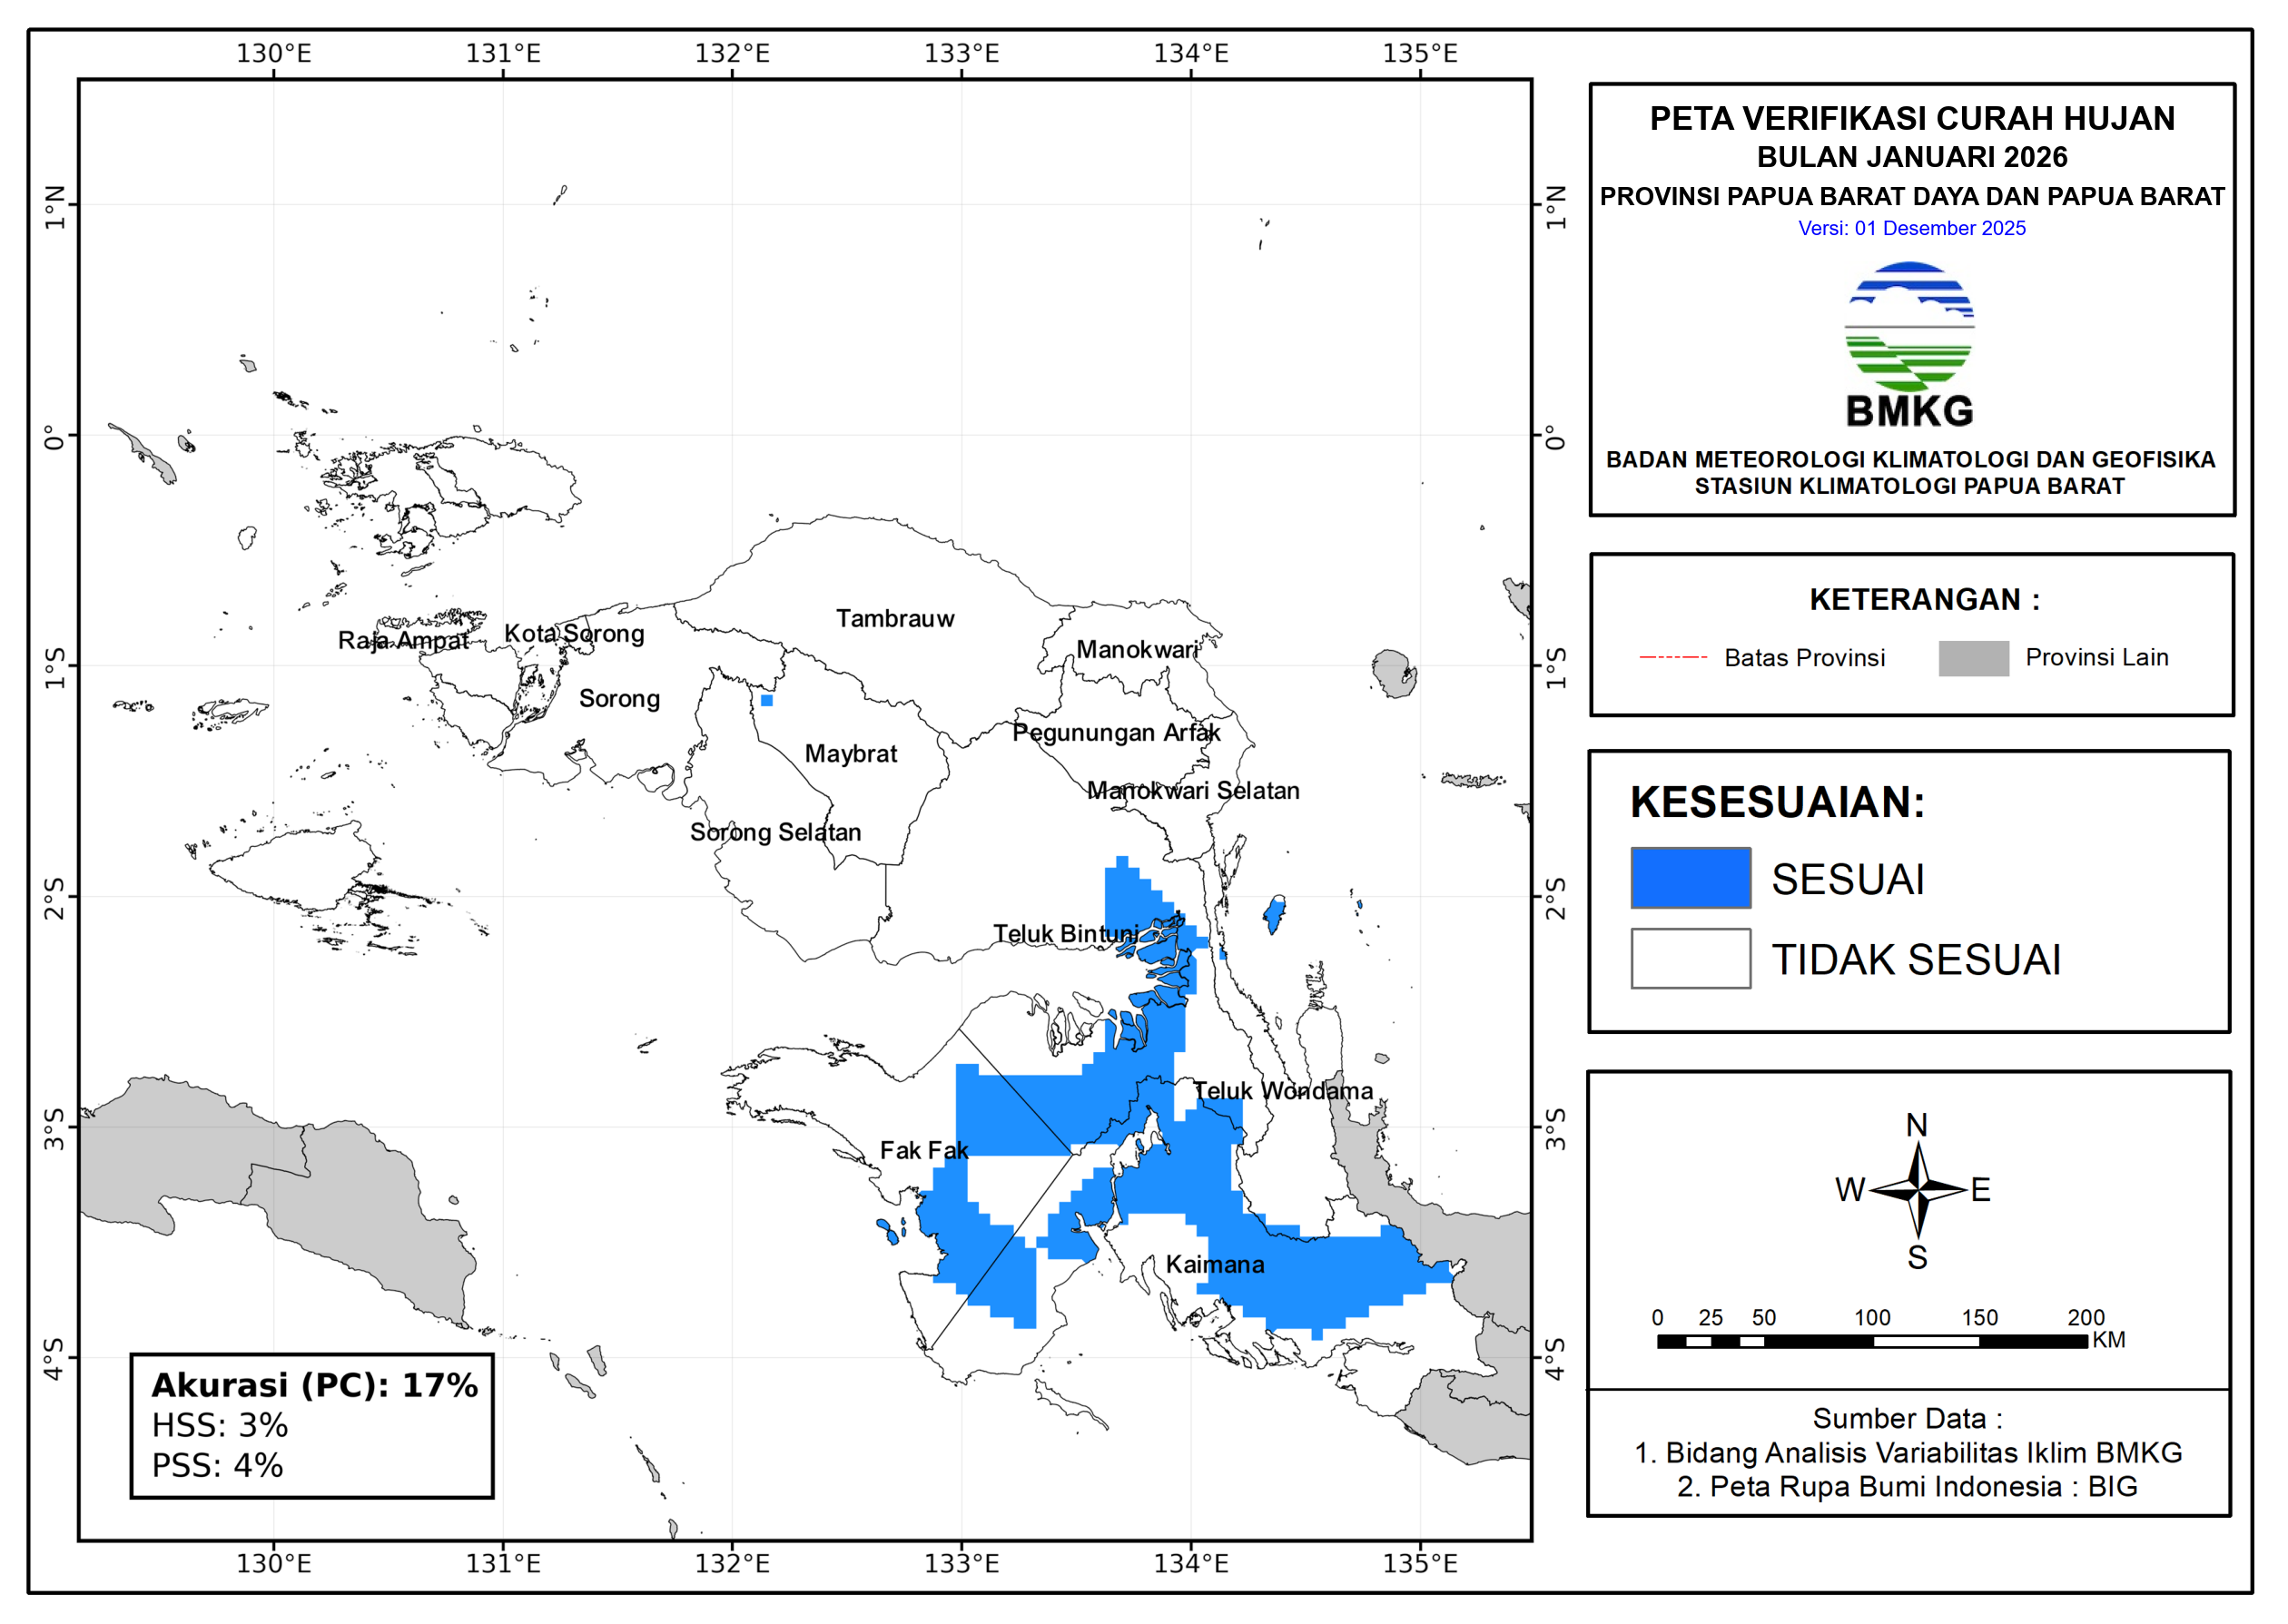

In [ ]:
result = {}

for peta in jenis_peta:
    result[peta] = {}
    for tipe in tipe_peta:
        result[peta][tipe] = []
        for skala in skala_peta:
            # Only add 'Curah Hujan' combinations for 'Probabilistik' and 'Normal'
            if (peta in ['Probabilistik', 'Normal','Verifikasi'] and tipe == 'Sifat Hujan') or \
              (peta == 'Normal' and tipe == 'Curah Hujan' and skala == 'Dasarian'):
                continue

            for month in months:
                month = month
                peta = peta
                tipe = tipe
                skala = skala
                if peta == 'Verifikasi':
                  month_ver = month_ver
                if month == 1:
                  year_ver = year - 1
                  month_ver = 12

                info = year, month, dasarian, year_ver, month_ver, dasarian_ver, wilayah
                execute(info)

